In [1]:
import pandas as pd
import numpy as np
import mlflow
from utils.metrics import Metrics_df,print_metrics, precision, recall, f1
import glob
from tqdm import tqdm
from utils.forest_infer import pred_multi


In [2]:
from Config import config
import warnings
warnings.filterwarnings("ignore")
import optuna  # pip install optuna
import gc

In [3]:
from lightgbm.basic import LightGBMError
from lightgbm import LGBMClassifier, early_stopping, log_evaluation, Booster
from sklearn.metrics import roc_auc_score
import os

# Loading data and group split

In [4]:
# df_pairs = pd.read_csv("/workspace/Training_data/training/Full_training_data.csv")
# df_pairs = df_pairs.sample(frac=1).reset_index(drop=True)
# kf = GroupKFold(n_splits=5)
# for i, (trn_idx, val_idx) in enumerate(kf.split(df_pairs, df_pairs["placeId1"], df_pairs["placeId1"])):
#     df_pairs.loc[val_idx, "fold"] = i
# df_pairs["fold"].value_counts()
# df_pairs.to_csv("/workspace/Training_data/training/Full_training_data_fold.csv",index=None)

# Loading data

In [5]:
df_pairs = pd.read_csv("/workspace/Training_data/training/Full_training_data_fold_v4_without_categories.csv")

In [6]:
features = ['similarity', 'haversine', 'name_davies',
       'name_leven', 'name_dice', 'name_jaro', 'name_set_ratio',
       'street_davies', 'street_leven', 'street_jaro', 'email_davies',
       'email_leven', 'email_jaro', 'url_davies', 'url_leven', 'url_jaro',
       'brands_davies', 'brand_leven', 'brand_jaro', 'phone_lcs',
       'subcat_WRatio', 'subcat_ratio', 'subcat_token_set_ratio',
       'Is_direction_match_0', 'Is_direction_match_1', 'Is_direction_match_2',
       'Is_house_match_0', 'Is_house_match_1', 'Is_house_match_2',
       'Is_category_match_0', 'Is_category_match_1', 'Is_subcategory_match_0',
       'Is_subcategory_match_1', 'Is_subcategory_match_2', 'Is_brand_match_0',
       'Is_brand_match_1', 'Is_brand_match_2', 'Is_brand_match_3',
       'Is_related_cat_0', 'Is_related_cat_1', 'Is_name_number_match_0',
       'Is_name_number_match_1', 'Is_name_number_match_2',
       'Is_name_number_match_3', 'is_phone_match_1', 'is_phone_match_2',
       'is_phone_match_3', 'is_phone_match_4', 'Is_email_match_0',
       'Is_email_match_1', 'Is_email_match_2', 'Is_url_match_0',
       'Is_url_match_1', 'Is_url_match_2']

In [7]:
class CheckpointCallback:
    """
    Save model weights callback.
    """
    def __init__(self, period,iter, **kwargs):
        self.iter = iter
        self.period = period
        self.before_iteration = False
        self.kwargs = kwargs

    def __call__(self, env):
        if self.period > 0 and env.iteration >= 100 and (env.iteration + 1) % self.period == 0:
            env.model.save_model('/workspace/models/' + f"model_duplicate_gsplit_lgb_{self.iter}.txt")


In [8]:
params =  {
    "learning_rate": 0.05,
    "num_leaves": 1140,
    "reg_alpha": 0,
    "reg_lambda": 30,
    "min_child_samples": 900,
    "min_split_gain": 7.69,
    "path_smooth": 1,
    "subsample_freq":1,
    "colsample_bytree":0.7,
    "max_bin":193,
    "max_depth":12,
    "subsample":0.8

}

In [9]:
for fold in [0,1,2,3,4]:

    model = LGBMClassifier(
    **params,
    n_jobs=-1,
    n_estimators=10000,
    snapshot_freq=100
    )

    callbacks = [log_evaluation(40), CheckpointCallback(100,fold)]
    callbacks += [early_stopping(100)]
    
    model.fit(df_pairs[df_pairs["fold"]!=fold][features],df_pairs[df_pairs["fold"]!=fold]["duplicate_flag"],
    eval_set=[(df_pairs[df_pairs["fold"]==fold][features], df_pairs[df_pairs["fold"]==fold]["duplicate_flag"])],
    callbacks=callbacks,eval_metric="auc")



Training until validation scores don't improve for 100 rounds
[40]	valid_0's auc: 0.99915	valid_0's binary_logloss: 0.0529871
[80]	valid_0's auc: 0.999583	valid_0's binary_logloss: 0.0174294
[120]	valid_0's auc: 0.999818	valid_0's binary_logloss: 0.0107623
[160]	valid_0's auc: 0.999859	valid_0's binary_logloss: 0.00927448
[200]	valid_0's auc: 0.999871	valid_0's binary_logloss: 0.00886769
[240]	valid_0's auc: 0.999877	valid_0's binary_logloss: 0.0087104
[280]	valid_0's auc: 0.999878	valid_0's binary_logloss: 0.00866593
[320]	valid_0's auc: 0.999879	valid_0's binary_logloss: 0.00863368
[360]	valid_0's auc: 0.99988	valid_0's binary_logloss: 0.00860759
[400]	valid_0's auc: 0.99988	valid_0's binary_logloss: 0.00858396
[440]	valid_0's auc: 0.999881	valid_0's binary_logloss: 0.00857188
[480]	valid_0's auc: 0.999881	valid_0's binary_logloss: 0.00855701
[520]	valid_0's auc: 0.999882	valid_0's binary_logloss: 0.00854716
[560]	valid_0's auc: 0.999882	valid_0's binary_logloss: 0.00853562
[600]	val

# Inference validation

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 15)
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams["legend.loc"] = 'best'


<AxesSubplot: >

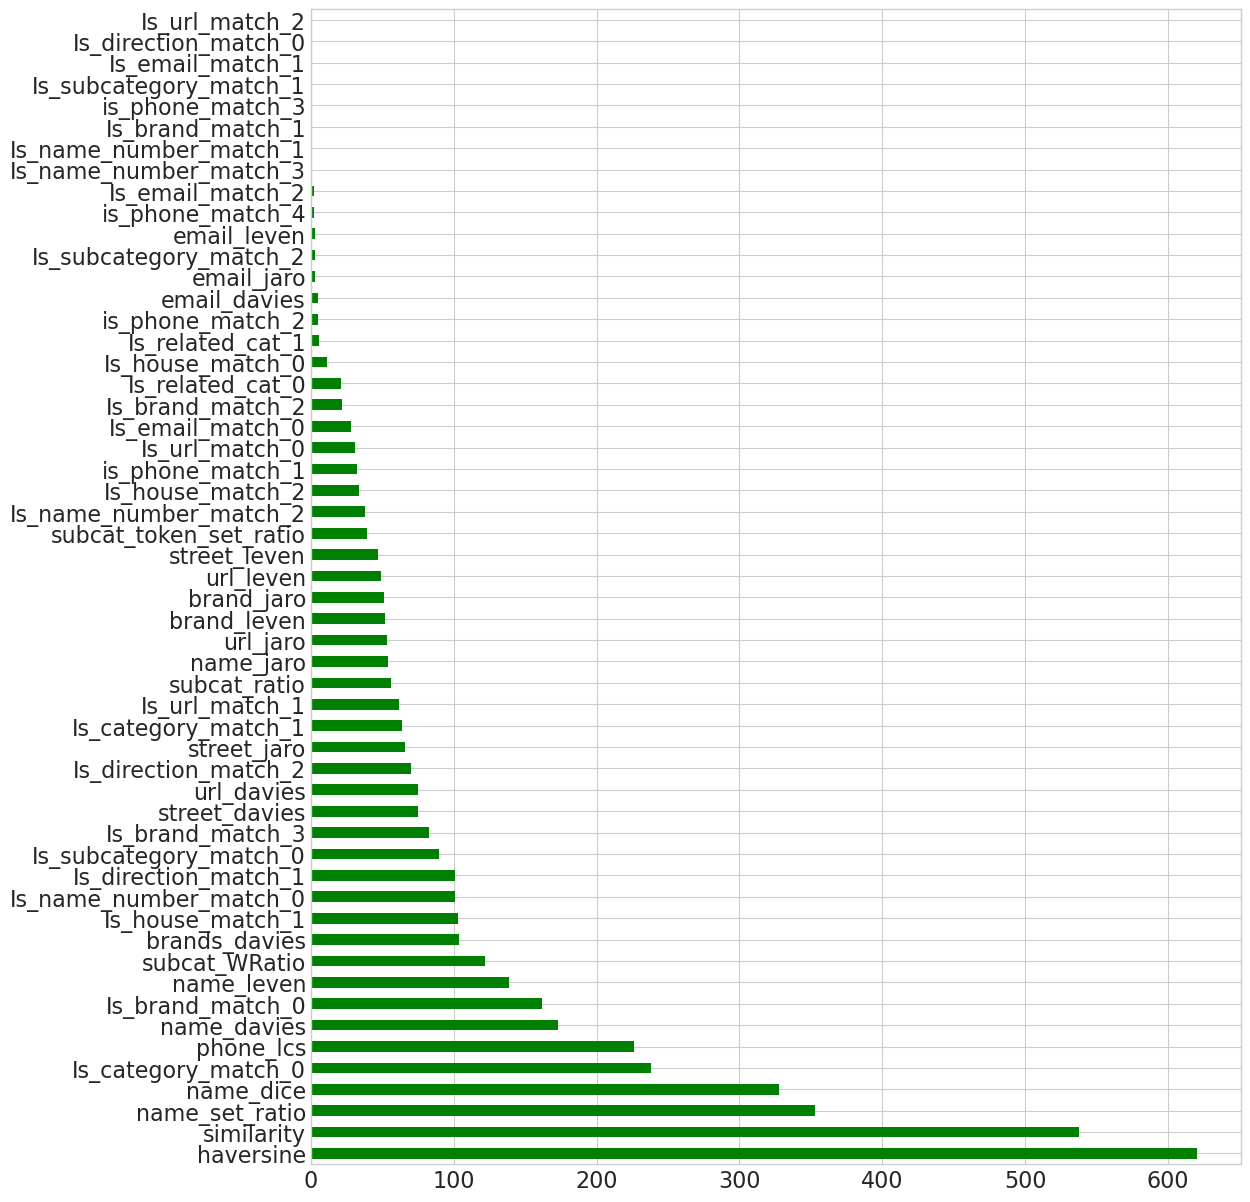

In [13]:
feat_importances = pd.Series(model.feature_importances_, index=model.feature_name_)
feat_importances.nlargest(70).plot(kind='barh', color='green')


In [15]:
models = glob.glob(f"/workspace/models/model_duplicate_gsplit_lgb*")

In [16]:
models

['/workspace/models/model_duplicate_gsplit_lgb_0.txt',
 '/workspace/models/model_duplicate_gsplit_lgb_1.txt',
 '/workspace/models/model_duplicate_gsplit_lgb_2.txt',
 '/workspace/models/model_duplicate_gsplit_lgb_3.txt',
 '/workspace/models/model_duplicate_gsplit_lgb_4.txt']

In [17]:
ltable_id = []
rtable_id = []
duplicate_flag = []
ltable_id = ltable_id + list(df_pairs["placeId1"])
rtable_id = rtable_id + list(df_pairs["placeId2"])

duplicate_flag = duplicate_flag + list(df_pairs["duplicate_flag"])
all_pred = []
for model_file in tqdm(models):
    prediction = pred_multi(model_file,df_pairs[features])
    all_pred.append(prediction)

  0%|          | 0/5 [00:00<?, ?it/s]

[W] [12:07:41.038716] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native LightGBM invocation.


  0%|          | 0/1714 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:14<00:59, 14.83s/it]

[W] [12:07:45.834516] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native LightGBM invocation.


  0%|          | 0/1714 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:18<00:24,  8.31s/it]

[W] [12:07:49.585879] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native LightGBM invocation.


  0%|          | 0/1714 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:22<00:12,  6.20s/it]

[W] [12:07:53.249744] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native LightGBM invocation.


  0%|          | 0/1714 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:26<00:05,  5.23s/it]

[W] [12:07:56.990587] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native LightGBM invocation.


  0%|          | 0/1714 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:29<00:00,  5.94s/it]


In [18]:
df = pd.DataFrame(list(
    zip(ltable_id, rtable_id, all_pred[0], all_pred[1], all_pred[2],all_pred[3],all_pred[4],duplicate_flag)),
                columns=['ltable_id', 'rtable_id', 'prediction1','prediction2', 'prediction3','prediction4','prediction5','duplicate_flag'])
df["prediction"] = df["prediction1"] + df["prediction2"] + df["prediction3"] + df["prediction4"] + df["prediction5"]
df["prediction"] = df["prediction"] / 5

0.9999097178501098


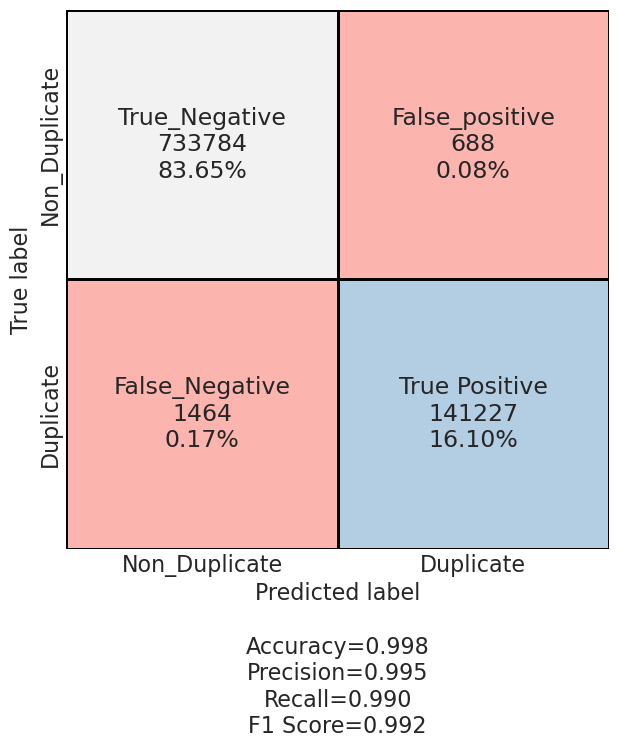

In [19]:
fig_conf= print_metrics(df["duplicate_flag"],df["prediction"])